In [7]:
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier

In [8]:
df = pd.read_csv('cleaned_data.csv')

In [9]:
df

,sms,label
0,ممنوع تصوير يرجى اعاد ارسال,0
1,شراء بيض,0
2,شيء,0
3,احتل طاول انتظار شجر,0
4,خير انت صلاح جد لذل اجاز يوم,0
...,...,...
1363,جيدلنشكر لهيرجى اكمال دواءلديك كثير ماءواستمتع...,0
1364,تاخذ دروس عمل ابدء,0
1365,تقلقساشتر شرايط اختبار اباض ارسل اليكل تحصل ما...,0
1366,غاب مكالم لان كنت اصرخ مشتاق لكل استطيع انتظار...,0


In [10]:
pd.set_option('display.max_colwidth', None)


In [11]:
def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    
    # Train a vectorizer on X_train data.
    # Transform X_train and X_test data.
    
    # Pickle the trained vectorizer to 'vectorizer_path'
    # Don't forget to open the file in writing bytes mode.
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
        
    return X_train, X_test

In [12]:
print(f"the dataframe shape: {df.shape}")
df.head()

the dataframe shape: (1368, 2)


,sms,label
0,ممنوع تصوير يرجى اعاد ارسال,0
1,شراء بيض,0
2,شيء,0
3,احتل طاول انتظار شجر,0
4,خير انت صلاح جد لذل اجاز يوم,0


Number of dialect classes: 2


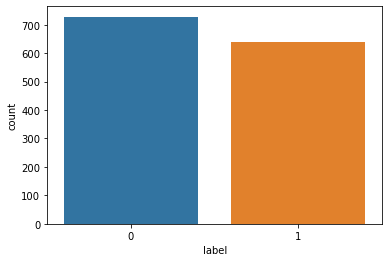

In [15]:
counts = df.label.value_counts()
print(f"Number of dialect classes: {df.label.nunique()}")
counts_df = pd.DataFrame(counts.to_dict().items(), columns=["label", "count"])
sns.barplot(data = counts_df, x="label", y="count", order=counts_df['label']);

In [30]:
X = df["sms"].values.astype('U') # You need to convert the dtype object to unicode for using tfidf_vectorizer
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify= y) ######### YOUR CODE HERE ##########
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, "Models/tfidf_vectorizer.pkl")

Train size = 820, test size = 548


In [31]:
(unique, counts) = np.unique(y_train, return_counts=True)
cw_dict = dict(zip(unique, np.around(1/counts *counts.max(),3)))
class_weight = cw_dict
print(class_weight)

{0: 1.0, 1: 1.135}


In [32]:
def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred))
    
    fig, ax = plt.subplots(1,2,figsize= (30,15))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[0]);
    ax[0].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[0].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[0].set_ylabel('Actual dialect',font ={'weight' : 'bold'})

    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[1]);
    ax[1].set_title(f"[{modelname}]Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect',font ={'weight' : 'bold'})
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    with open("Models/"+ modelname + ".pkl", 'wb') as f:
        pickle.dump(model, f)

-------------------------- [Logistic] --------------------------
Train accuracy = 0.9524390243902439
Test accuracy = 0.9233576642335767
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       292
           1       0.93      0.90      0.92       256

    accuracy                           0.92       548
   macro avg       0.92      0.92      0.92       548
weighted avg       0.92      0.92      0.92       548



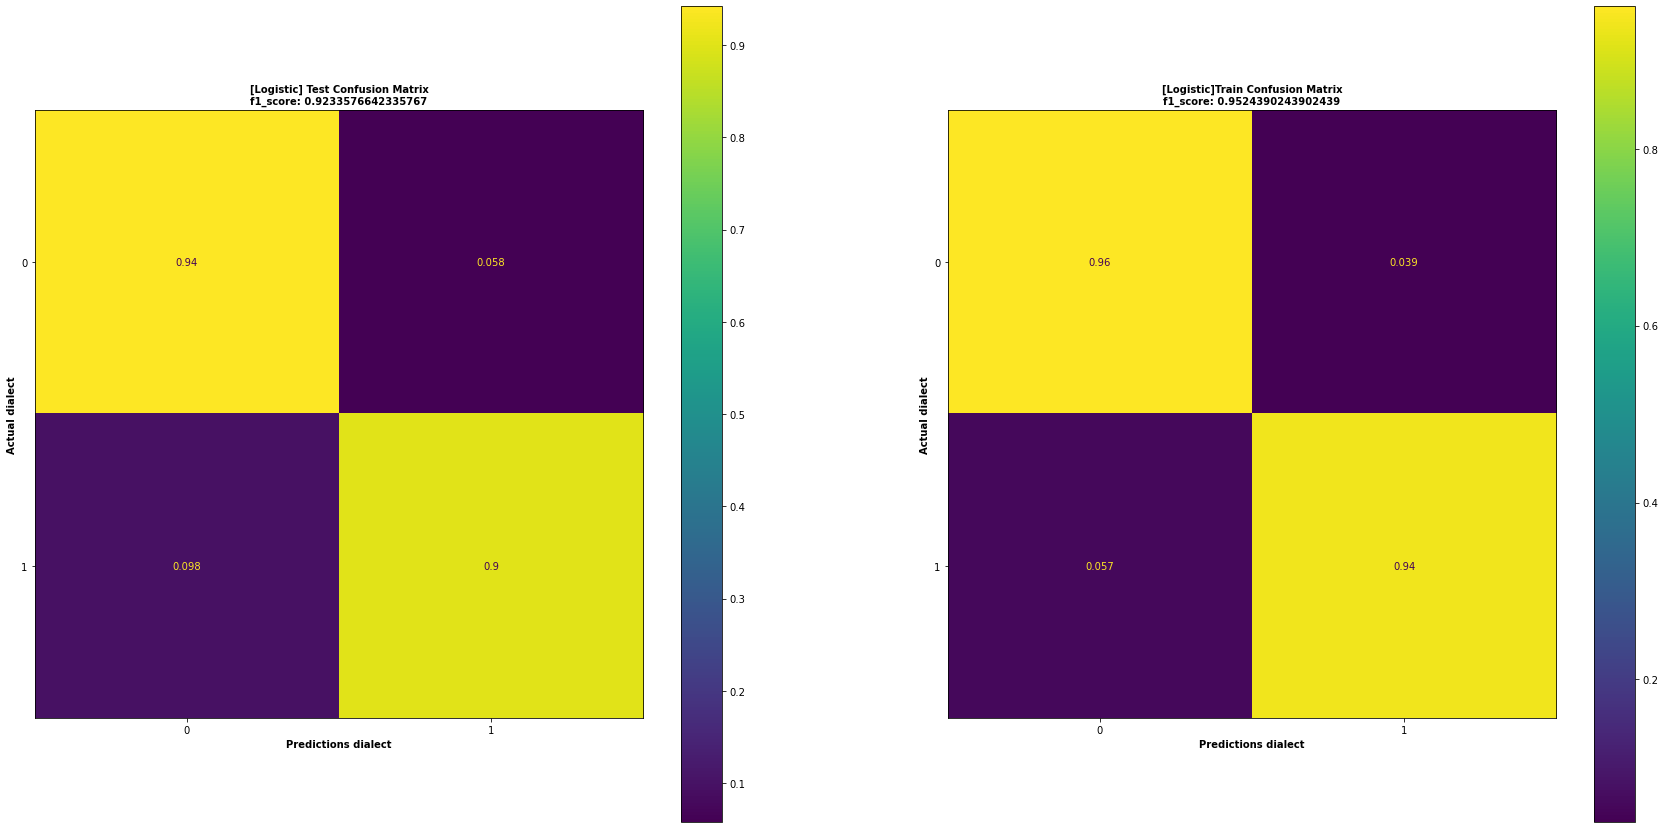

In [33]:
dialect_recognizer = LogisticRegression(penalty='l2', C=1, random_state=0, solver='liblinear', class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer,"Logistic", X_train_tfidf, X_test_tfidf, y_train, y_test)

-------------------------- [ComplementNaiveBayes] --------------------------
Train accuracy = 0.9378048780487804
Test accuracy = 0.9124087591240876
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       292
           1       0.90      0.92      0.91       256

    accuracy                           0.91       548
   macro avg       0.91      0.91      0.91       548
weighted avg       0.91      0.91      0.91       548



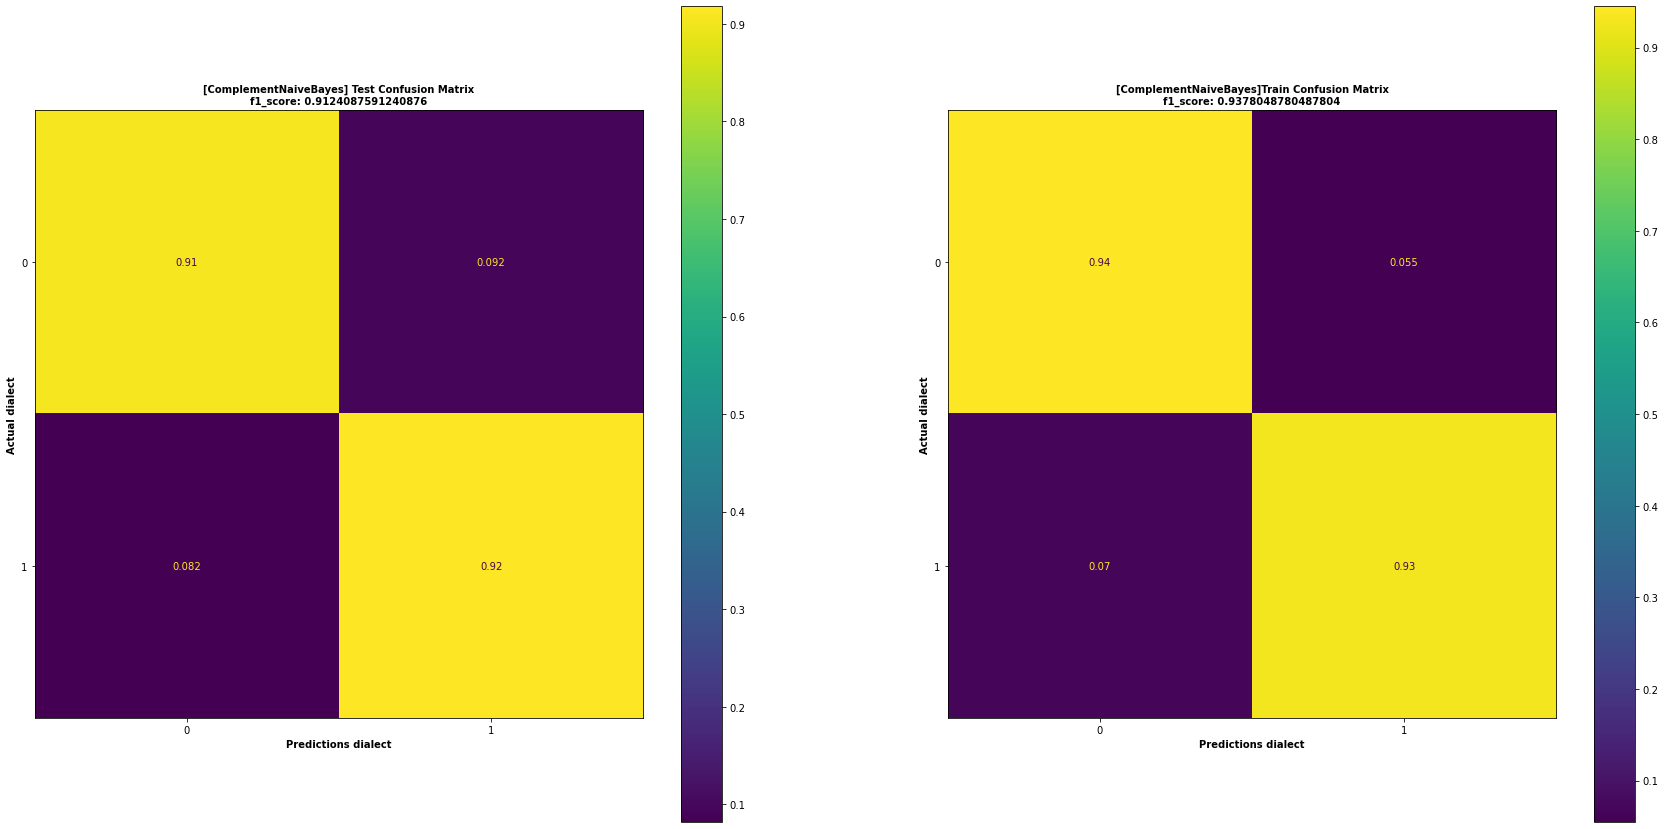

In [34]:
dialect_recognizer = ComplementNB()
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "ComplementNaiveBayes", X_train_tfidf, X_test_tfidf, y_train, y_test)

-------------------------- [SGDClassifier] --------------------------
Train accuracy = 0.9878048780487805
Test accuracy = 0.8978102189781022
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       292
           1       0.88      0.90      0.89       256

    accuracy                           0.90       548
   macro avg       0.90      0.90      0.90       548
weighted avg       0.90      0.90      0.90       548



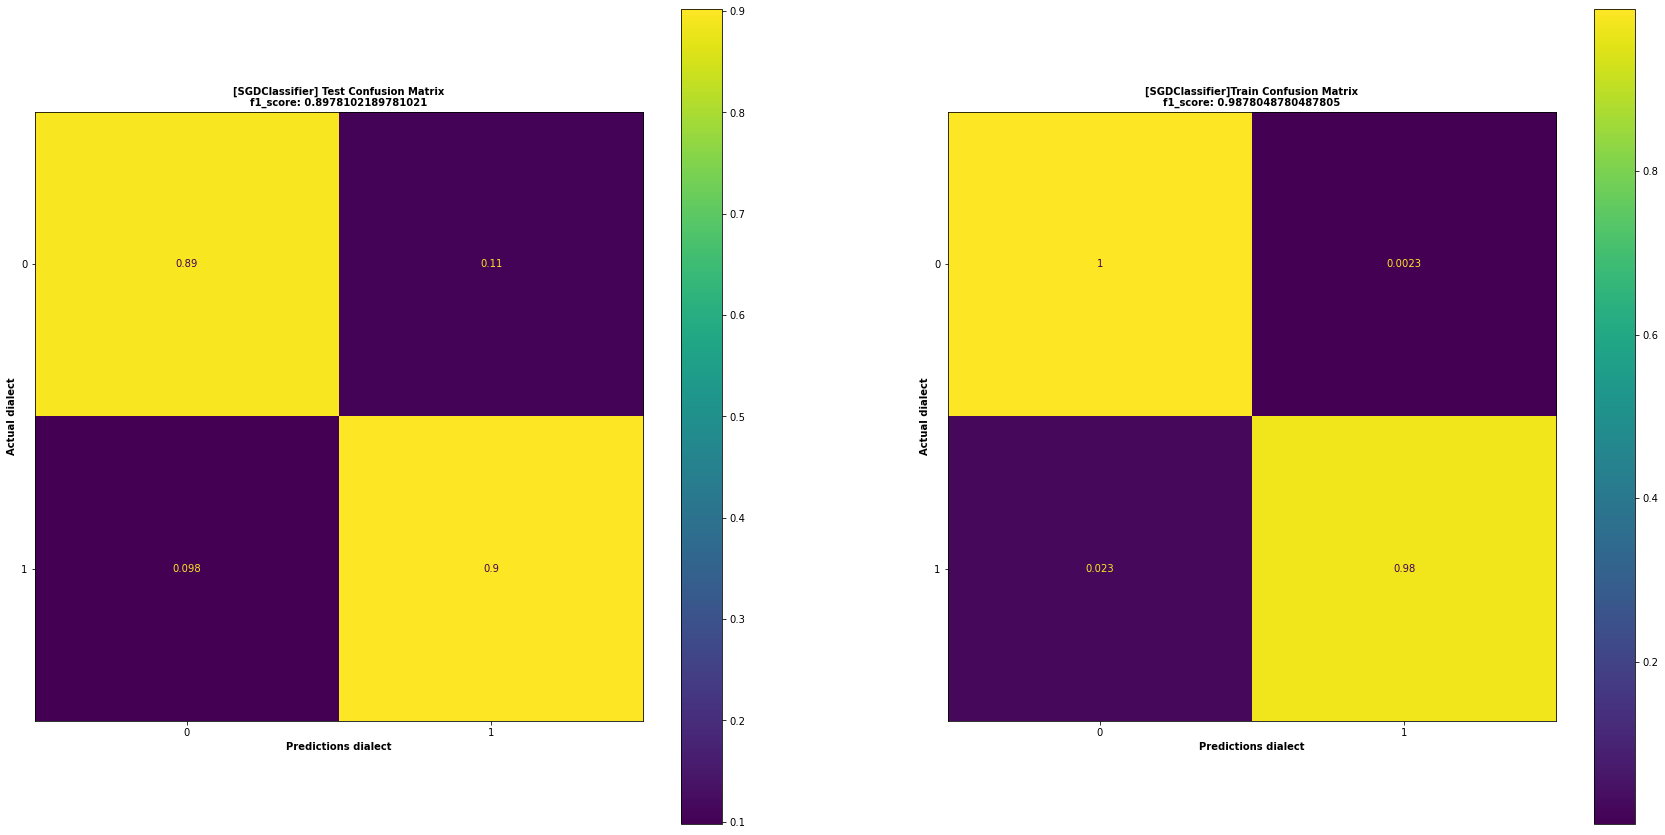

In [35]:
dialect_recognizer = SGDClassifier(loss='hinge', n_jobs=-1, class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "SGDClassifier", X_train_tfidf, X_test_tfidf, y_train, y_test)